In [317]:
import pandas as pd
import plotly as plt
import plotly.express as px
import plotly.graph_objs as go
from typing import Optional, List
import numpy as np
import os

# Exploration
## Loading

In [318]:
columns = pd.read_csv("../data/_columns.csv")
bans = pd.read_csv("../data/bans.csv")
gold = pd.read_csv("../data/gold.csv")
kills = pd.read_csv("../data/kills.csv")
matchinfo = pd.read_csv("../data/matchinfo.csv")
monsters = pd.read_csv("../data/monsters.csv")
structures = pd.read_csv("../data/structures.csv")

pickban dataset, put picks along bans

In [319]:
data_dfs = [bans,gold,kills,matchinfo,monsters,structures]

It seems that LeagueofLegends already aggregates all the data, things with a list are strings though.
I think for our usecase we can simply ignore LeagueofLegends, using the separated data will be clearer.
## Making ids
We should replace the "Address" with an id

In [320]:
matchinfo[matchinfo.isna().any(axis=1)]

League  Year  Season    Type blueTeamTag  bResult  rResult redTeamTag  \
3422    LMS  2015  Spring  Season         NaN        1        0        ahq   
5924    LJL  2016  Summer  Season         NaN        0        1        NaN   
5925    LJL  2016  Summer  Season         NaN        1        0        NaN   
5926    LJL  2016  Summer  Season         NaN        1        0        NaN   
5927    LJL  2016  Summer  Season         NaN        1        0        NaN   
5928    LJL  2016  Summer  Season         NaN        1        0        NaN   
5929    LJL  2016  Summer  Season         NaN        1        0        NaN   
5930    LJL  2016  Summer  Season         NaN        1        0        NaN   
5931    LJL  2016  Summer  Season         NaN        0        1        NaN   
5932    LJL  2016  Summer  Season         NaN        0        1        NaN   
5933    LJL  2016  Summer  Season         NaN        0        1        NaN   
5934    LJL  2016  Summer  Season         NaN        0        1        NaN   
5935    LJL  2016  Summer  Season         NaN        1        0        NaN   
5936    LJL  2016  Summer  Season         NaN        0        1        NaN   
5937    LJL  2016  Summer  Season         NaN        1        0        NaN   
5938    LJL  2016  Summer  Season         NaN        0        1        NaN   
5939    LJL  2016  Summer  Season         NaN        1        0        NaN   
5940    LJL  2016  Summer  Season         NaN        0        1        NaN   
5941    LJL  2016  Summer  Season         NaN        0        1        NaN   
5942    LJL  2016  Summer  Season         NaN        0        1        NaN   
5943    LJL  2016  Summer  Season         NaN        0        1        NaN   
5944    LJL  2016  Summer  Season         NaN        0        1        NaN   
5945    LJL  2016  Summer  Season         NaN        0        1        NaN   
5946    LJL  2016  Summer  Season         NaN        0        1        NaN   
5947    LJL  2016  Summer  Season         NaN        0        1        NaN   
5948    LJL  2016  Summer  Season         NaN        1        0        NaN   
5949    LJL  2016  Summer  Season         NaN        0        1        NaN   
5950    LJL  2016  Summer  Season         NaN        1        0        NaN   
5951    LJL  2016  Summer  Season         NaN        1        0        NaN   
5952    LJL  2016  Summer  Season         NaN        0        1        NaN   
5953    LJL  2016  Summer  Season         NaN        1        0        NaN   
5954    LJL  2016  Summer  Season         NaN        1        0        NaN   
5955    LJL  2016  Summer  Season         NaN        1        0        NaN   
5956    LJL  2016  Summer  Season         NaN        1        0        NaN   
5957    LJL  2016  Summer  Season         NaN        1        0        NaN   
5958    LJL  2016  Summer  Season         NaN        0        1        NaN   
5959    LJL  2016  Summer  Season         NaN        1        0        NaN   
5960    LJL  2016  Summer  Season         NaN        0        1        NaN   

      gamelength blueTop  ... redTopChamp redJungle redJungleChamp redMiddle  \
3422          32   Steak  ...      Maokai     Albis         LeeSin  westdoor   
5924          27     NaN  ...   TahmKench       NaN         Graves       NaN   
5925          41     NaN  ...        Ekko       NaN         Gragas       NaN   
5926          31     NaN  ...      Maokai       NaN         Gragas       NaN   
5927          47     NaN  ...        Ekko         =         RekSai       NaN   
5928          29     NaN  ...        Ekko       NaN         Gragas       NaN   
5929          61     NaN  ...      Maokai         =         RekSai       NaN   
5930          34     NaN  ...        Gnar       NaN         Gragas       NaN   
5931          36     NaN  ...        Ekko       NaN         Graves       NaN   
5932          33     NaN  ...     Trundle       NaN         LeeSin       NaN   
5933          42     NaN  ...        Ekko       NaN          Elise       NaN   
59

In [321]:
matchinfo = matchinfo.dropna()

In [322]:
match_ids = matchinfo["Address"].reset_index()
match_ids = match_ids.rename(columns={"index":"match_id"})

Testing code for the replacement:
```python
kills=kills.merge(match_ids, on="Address",how="left")
kills.drop(columns=["Address"],inplace=True)
```

In [323]:
for i in range(len(data_dfs)):
    data_dfs[i]=data_dfs[i].merge(match_ids, on="Address",how="inner")
    data_dfs[i].drop(columns=["Address"],inplace=True)
bans,gold,kills,matchinfo,monsters,structures = data_dfs
    

In [324]:
bans['Team'] = bans['Team'].apply(lambda x: 'red' if x[0]=='r' else 'blue')
bans = bans.rename(columns={"ban_1":"Ban1","ban_2":"Ban2","ban_3":"Ban3","ban_4":"Ban4","ban_5":"Ban5"})
bans = bans.drop_duplicates().pivot(index='match_id',columns='Team',values=["Ban1","Ban2","Ban3","Ban4","Ban5"])
bans.columns = bans.columns.map(lambda col: f"{col[1]}{col[0]}")
matchinfo = matchinfo.merge(bans,on='match_id')

In [325]:
matchinfo = matchinfo.merge(bans,on='match_id')


## Plan
Prepare datasets, do any needed preprocessing.

Prepare large views in advance? Like map events.
## Kills
- Change coordinates to numeric
- replace Team by clear BLUE or RED

In [326]:
# Convert kill positions to numbers, coerce will convert or if not possible replace with NaN
kills['x_pos'] = pd.to_numeric(kills['x_pos'],errors='coerce')
kills['y_pos'] = pd.to_numeric(kills['y_pos'],errors='coerce')
kills['Team'] = kills['Team'].apply(lambda x: 'RED' if x[0]=='r' else 'BLUE')

In [391]:
fix_g=kills[kills['match_id']==7619]

In [393]:
def add_map_bg(fig):
    fig.update_traces(opacity=0.66)
    fig.update_layout(
        images=[
            dict(
                source="..\\ressources\\SummonersRift.webp",  # Path or URL to the PNG/SVG image
                xref="paper",  # Coordinates system: 'paper' means relative to the paper's area
                yref="paper",
                x=0,  # Positioning the image
                y=1,  # Positioning the image
                sizex=1,  # Image width as a fraction of plot area
                sizey=1,  # Image height as a fraction of plot area
                opacity=0.3,  # Image transparency (0 = fully transparent, 1 = fully opaque)
                layer="below"  # Ensures the image stays below the plot
            )
        ],
    )
    return fig

In [329]:
def combine_assists(row: pd.Series, assist_cols: List[str]) -> Optional[str]:
    assists = [str(row[col]) for col in assist_cols if pd.notna(row[col])]
    return ", ".join(assists) if assists else None

def format_time(minutes: float) -> str:
    total_seconds = int(minutes * 60)
    h = total_seconds // 3600
    m = (total_seconds % 3600) // 60
    s = total_seconds % 60
    if h > 0:
        return f"{h:02}:{m:02}:{s:02}"
    else:
        return f"{m}:{s:02}"

In [330]:
def get_kill_plot(df: pd.DataFrame) -> go.Figure:
    assist_columns = ["Assist_1", "Assist_2", "Assist_3", "Assist_4"]
    assists = df.apply(lambda x: combine_assists(x, assist_columns), axis=1)
    formatted_time = df['Time'].apply(lambda x: format_time(float(x)))
    fig = px.scatter(
        data_frame=df,
        x=df['x_pos'],
        y=df['y_pos'],
        title="Deaths",
        width=800,
        height=800,
        #color=df['Team'].apply(lambda x: 'RED' if x=='BLUE' else 'BLUE'), # Binds colour to victim (flip), more intuitive for the one looking
        color='Team',
        color_discrete_map={'RED':'blue','BLUE':'red'},
        labels={'Team':'Team','BLUE': 'Red', 'RED': 'Blue'},
        hover_name='Victim',
        hover_data={
            'x_pos': False,
            'y_pos': False,
            'Team': False,
            'At ': formatted_time,
            'Killer': True,
            'Assists': assists,
        }
    )
    fig.update_traces(marker=dict(size=15))
    add_map_bg(fig)
    return fig

In [496]:
kills['match_id'].unique().size

7582

In [508]:
def get_kill_plot_single(df: pd.DataFrame) -> go.Figure:
    assist_columns = ["Assist_1", "Assist_2", "Assist_3", "Assist_4"]
    assists = df.apply(lambda x: combine_assists(x, assist_columns), axis=1)
    formatted_time = df['Time'].apply(lambda x: format_time(float(x)))
    fig = px.scatter(
        data_frame=df,
        x=df['x_pos'],
        y=df['y_pos'],
        title="Deaths",
        width=800,
        height=800,
        #color=df['Team'].apply(lambda x: 'RED' if x=='BLUE' else 'BLUE'), # Binds colour to victim (flip), more intuitive for the one looking
        color='Team',
        color_discrete_map={'RED':'blue','BLUE':'red'},
        labels={'Team':'Team','BLUE': 'Red', 'RED': 'Blue'},
        hover_name='Victim',
        hover_data={
            'x_pos': False,
            'y_pos': False,
            'Team': False,
            'At ': formatted_time,
            'Killer': True,
            'Assists': assists,
        }
    )
    fig.update_traces(marker=dict(size=15))
    return fig

def get_kill_plot_aggregate(df: pd.DataFrame) -> go.Figure:
    df_div = df
    df_div['x_pos'] = (df_div['x_pos']/kills['x_pos'].max()*heatmap_binsize).apply(math.floor)
    df_div['y_pos'] = (df_div['y_pos']/kills['y_pos'].max()*heatmap_binsize).apply(math.floor)
    df_div = df_div.groupby(['x_pos', 'y_pos', 'Team']).agg(count=('Time', 'count'),avg_time=('Time', 'mean')).reset_index()
    formatted_time = df_div['avg_time'].apply(lambda x: format_time(float(x)))
    fig = px.scatter(
        data_frame=df_div,
        y=df_div['y_pos'],
        x=df_div['x_pos'],
        title="Deaths",
        width=800,
        height=800,
        color='Team',
        color_discrete_map={'RED':'blue','BLUE':'red'},
        labels={'Team':'Team','BLUE': 'Red', 'RED': 'Blue'},
        hover_data={
            'count': True,
            'At ': formatted_time,
        },
        size='count',
    )
    return fig

def get_kill_plot(df: pd.DataFrame) -> go.Figure:
    if df['match_id'].unique().size == 1: fig = get_kill_plot_single(df)
    else: fig = get_kill_plot_aggregate(df)
    add_map_bg(fig)
    return fig

In [511]:
import math
heatmap_binsize = 25
kills_div = kills.copy()
kills_div['x_pos'] = (kills_div['x_pos']/kills['x_pos'].max()*heatmap_binsize).apply(math.floor)
kills_div['y_pos'] = (kills_div['y_pos']/kills['y_pos'].max()*heatmap_binsize).apply(math.floor)

In [498]:
kills_div.groupby(['x_pos', 'y_pos', 'Team']).agg(count=('Time', 'count'),avg_time=('Time', 'mean')).reset_index()


x_pos  y_pos  Team  count   avg_time
0         0      0   RED      2  32.396000
1         0      1   RED      9  33.430444
2         0      2  BLUE      1  28.536000
3         0      2   RED      3  36.959333
4         0      5   RED      1  34.894000
...     ...    ...   ...    ...        ...
4214     49     48  BLUE     18  33.455056
4215     49     48   RED      7  33.508429
4216     49     49  BLUE     20  33.945500
4217     49     49   RED      5  29.517200
4218     50     48  BLUE      1  32.114000

[4219 rows x 5 columns]

In [512]:
fig = get_kill_plot(kills)
# Add timeframe
fig.show()

In [395]:
def get_kill_heatmap(df: pd.DataFrame, heatmap_binsize: int):
    fig=px.density_heatmap(
        x=df['x_pos'],
        y=df['y_pos'],
        nbinsx=heatmap_binsize, # Define "size" of blocks
        nbinsy=heatmap_binsize,
        title="Kills",
        width=800,
        height=800,
        color_continuous_scale='Viridis'
        )
    add_map_bg(fig)
    return fig


### Turret positions (x,y)
Red Top 1 - (1000,10000)
Red Top 2 - (1600, 6200)
Red Top 3 - (1200, 4000)
Red Top inhib - (1100, 3500)
Red Mid 1 - (5800, 6000)
Red Mid 2 - (5200,4300)
Red Mid 3 - (3700, 3200)
Red Mid inhib - (3300,3200)
Red Bot 1 - (10500, 700)
Red Bot 2 - (6800, 1500)
Red Bot 3 - (4200,1200)
Red Bot inhib - (3400,1200)
Red Nexus 1 - (1700,2200)
Red Nexus 2 - (2100, 1700)

In [397]:
heatmap_binsize = 50

In [398]:
fig = get_kill_heatmap(kills,heatmap_binsize)
fig.show()

```python
fig.update_layout(
    yaxis=dict(scaleanchor="x")  # Locks x and y scaling
) 
```
This would lock x and y to equal scaling.

Summoners' Rift image from: https://www.reddit.com/r/leagueoflegends/comments/pl92ho/vector_map_of_summoners_rift_wip/

Things to filter by: blue team, red team, team name, player, by minute N, between minutes N and T.

Scatterplot version for single games.
## Monsters

We have elemental drakes. I suggest adding a column to check if it's a drake at all and one to check if it's a first drake, soul etc...
I would do a distribution of red/blue time for who takes first drake/herald/baron, as well as one giving the average time at which the first drake is taken, depending on its type.

In [334]:
matchinfo[matchinfo['blueTeamTag'] == 'Prime']

League  Year  Season       Type blueTeamTag  bResult  rResult redTeamTag  \
7378    LCK  2015  Summer  Promotion       Prime        0        1        SSG   
7381    LCK  2015  Summer  Promotion       Prime        0        1     Xenics   
7383    LCK  2015  Summer  Promotion       Prime        1        0     Xenics   

      gamelength blueTop  ...  blueBan1_y redBan1_y blueBan2_y   redBan2_y  \
7378          42    Soul  ...      LeeSin   Kalista        Zed  Cassiopeia   
7381          50    Soul  ...  Cassiopeia   Kalista       Sion     Leblanc   
7383          44    Soul  ...  Cassiopeia   Leblanc     RekSai     Kalista   

     blueBan3_y redBan3_y blueBan4_y redBan4_y blueBan5_y redBan5_y  
7378     Maokai      Azir        NaN       NaN        NaN       NaN  
7381    Hecarim      Lulu        NaN       NaN        NaN       NaN  
7383    Hecarim    Maokai        NaN       NaN        NaN       NaN  

[3 rows x 50 columns]

# TEAM SHORTHAND AND PLAYERNAMES SPLIT HERE

In [335]:
kills = kills[kills['Killer'] != 'TooEarly']
kills = kills.dropna(subset=['Victim']) # On Victim, because (although unclear) victim could die from neutral entity

In [336]:
kills.groupby(['Killer']).aggregate(count=('Killer','size')).reset_index().sort_values(by='count')

Killer  count
2529     as Zonda       1
2528      as BeBe       1
2527     as Achie       1
1974     S04 Boris      1
1944      ROX Mess      1
...            ...    ...
250      C9 Jensen   1068
257      C9 Sneaky   1149
2276  TSM Bjergsen   1382
2055     SKT Faker   1470
2049      SKT Bang   1569

[2569 rows x 2 columns]

In [337]:
matchinfo['blueTeamTag'] = matchinfo['blueTeamTag'].str.upper()
matchinfo['redTeamTag'] = matchinfo['redTeamTag'].str.upper()

In [339]:
# Merge kills with team tags based on match_id
kills = kills.merge(
    matchinfo.reset_index()[['match_id', 'blueTeamTag', 'redTeamTag']],
    on='match_id',
    how='left'
)
import numpy as np

kills['Killer_Team'] = np.where(kills['Team'] == 'BLUE', kills['blueTeamTag'], kills['redTeamTag'])
kills['Victim_Team'] = np.where(kills['Team'] == 'BLUE', kills['redTeamTag'], kills['blueTeamTag'])
kills.drop(columns=['blueTeamTag', 'redTeamTag'], inplace=True)


In [340]:
kills[kills["Time"].isna()]

Empty DataFrame
Columns: [Team, Time, Victim, Killer, Assist_1, Assist_2, Assist_3, Assist_4, x_pos, y_pos, match_id, Killer_Team, Victim_Team]
Index: []

In [377]:
player_cols = matchinfo.iloc[:,9::2].iloc[:,:10].columns

In [ ]:
all_usernames = pd.Series(pd.unique(matchinfo[player_cols].values.ravel())).dropna()

# Map lowercased usernames to their most common variant
most_common_variants = (
    all_usernames.groupby(all_usernames.str.lower())
    .agg(lambda x: x.value_counts().idxmax())
    .to_dict()
)

In [387]:
matchinfo[matchinfo["redADC"]=="Wildturtle"]

Empty DataFrame
Columns: [League, Year, Season, Type, blueTeamTag, bResult, rResult, redTeamTag, gamelength, blueTop, blueTopChamp, blueJungle, blueJungleChamp, blueMiddle, blueMiddleChamp, blueADC, blueADCChamp, blueSupport, blueSupportChamp, redTop, redTopChamp, redJungle, redJungleChamp, redMiddle, redMiddleChamp, redADC, redADCChamp, redSupport, redSupportChamp, match_id, blueBan1_x, redBan1_x, blueBan2_x, redBan2_x, blueBan3_x, redBan3_x, blueBan4_x, redBan4_x, blueBan5_x, redBan5_x, blueBan1_y, redBan1_y, blueBan2_y, redBan2_y, blueBan3_y, redBan3_y, blueBan4_y, redBan4_y, blueBan5_y, redBan5_y]
Index: []

[0 rows x 50 columns]

In [388]:
matchinfo[matchinfo["redADC"]=="WildTurtle"]

League  Year  Season           Type blueTeamTag  bResult  rResult  \
9     NALCS  2015  Spring         Season          T8        1        0   
22    NALCS  2015  Spring         Season         DIG        0        1   
34    NALCS  2015  Spring         Season          GV        0        1   
37    NALCS  2015  Spring         Season         CLG        0        1   
46    NALCS  2015  Spring         Season          TL        1        0   
...     ...   ...     ...            ...         ...      ...      ...   
6847    IEM  2016  Summer  International         UOL        1        0   
6848    IEM  2016  Summer  International         UOL        1        0   
7023  NALCS  2018  Spring         Season         FOX        1        0   
7559  NALCS  2018  Spring         Season         GGS        0        1   
7562  NALCS  2018  Spring         Season         OPT        1        0   

     redTeamTag  gamelength      blueTop  ... blueBan1_y redBan1_y blueBan2_y  \
9           TSM          32  CaliTrlolz8  ...     Rumble    RekSai      Janna   
22          TSM          36        Gamsu  ...     Rumble  JarvanIV   Kassadin   
34          TSM          43     Hauntzer  ...       Ahri     Corki    Leblanc   
37          TSM          46  ZionSpartan  ...     Xerath    Rumble    Leblanc   
46          TSM          54         Quas  ...    Kalista      Fizz     Maokai   
...         ...         ...          ...  ...        ...       ...        ...   
6847        TSM          30   Vizicsacsi  ...     Zilean    Syndra      Jayce   
6848        TSM          36   Vizicsacsi  ...     Zilean      Ryze      Jayce   
7023        FLY          30         Huni  ...    Kalista       Zoe  TahmKench   
7559        FLY          48       Lourlo  ...  Gangplank       Zoe       Azir   
7562        FLY          39          zig  ...     KogMaw   Orianna       Ryze   

      redBan2_y blueBan3_y  redBan3_y blueBan4_y redBan4_y blueBan5_y  \
9      JarvanIV   Kassadin  Lissandra        NaN       NaN        NaN   
22    Lissandra      Annie       Ahri        NaN       NaN        NaN   
34      Morgana    Nidalee    Kalista        NaN       NaN        NaN   
37      Morgana     Maokai    Nidalee        NaN       NaN        NaN   
46      Morgana        Zed         Vi        NaN       NaN        NaN   
...         ...        ...        ...        ...       ...        ...   
6847       Ryze      Karma  TahmKench        NaN       NaN        NaN   
6848     Syndra      Karma       Ashe        NaN       NaN        NaN   
7023       Azir   Tristana     Ezreal       Ornn   Camille      Jayce   
7559   Malzahar      Jayce       Gnar     Illaoi  JarvanIV      Fiora   
7562       Azir  Gangplank        Zoe        Zac    Rengar    Sejuani   

     redBan5_y  
9          NaN  
22         NaN  
34         NaN  
37         NaN  
46         NaN  
...        ...  
6847       NaN  
6848       NaN  
7023     Janna  
7559  Vladimir  
7562      Ornn  

[151 rows x 50 columns]

In [386]:
for col in player_cols:
    matchinfo[col] = matchinfo[col].str.lower().map(most_common_variants) # Keep only most recurring variatnt of username

In [372]:
def extract_username(full_str, team_tag):
    if pd.isna(full_str):
        return full_str
    
    parts = full_str.split(" ")
    if len(parts) < 2:
        return full_str  # Unusual format, return as-is
    
    if str(parts[0]).upper() == str(team_tag).upper():
        # Return second-to-last part (or last part if only 2 total)
        return " ".join(parts[1:]).capitalize()
    else:
        return full_str  # Assume already a username
cols_to_clean = ['Killer', 'Victim', 'Assist_1', 'Assist_2', 'Assist_3', 'Assist_4']

# Apply the function
for col in cols_to_clean:
    if 'Victim' in col:
        kills[col] = kills.apply(lambda row: extract_username(row[col], row['Victim_Team']), axis=1)
    else:
        kills[col] = kills.apply(lambda row: extract_username(row[col], row['Killer_Team']), axis=1)
    kills[col] = kills[col].str.lower().map(most_common_variants)


In [380]:
kills

Team    Time       Victim      Killer  Assist_1    Assist_2  \
0       BLUE  10.820          Hai    Bjergsen       NaN         NaN   
1       BLUE  16.286  LemonNation  WildTurtle  Santorin    Bjergsen   
2       BLUE  18.733          Hai    Bjergsen  Santorin  WildTurtle   
3       BLUE  18.880       Meteos       Dyrus  Santorin    Bjergsen   
4       BLUE  27.005        Balls    Bjergsen     Dyrus    Santorin   
...      ...     ...          ...         ...       ...         ...   
189922   RED  35.086      Papryze      Claire     Ceres       Sybol   
189923   RED  40.706          Low        Raid     Ceres       Sybol   
189924   RED  40.711       Swathe      Claire     Ceres       Sybol   
189925   RED  41.113      Tilting      Claire     Ceres       Sybol   
189926   RED  41.201      Papryze      Claire     Ceres       Sybol   

          Assist_3 Assist_4    x_pos   y_pos  match_id Killer_Team Victim_Team  
0              NaN      NaN   9229.0  8469.0         0         TSM          C9  
1          Lustboy      NaN  13908.0  5960.0         0         TSM          C9  
2          Lustboy      NaN   8281.0  7889.0         0         TSM          C9  
3       WildTurtle  Lustboy   8522.0  8895.0         0         TSM          C9  
4       WildTurtle  Lustboy   8902.0  7643.0         0         TSM          C9  
...            ...      ...      ...     ...       ...         ...         ...  
189922        Raid    Decoy   6424.0  9256.0      7619         LGC         TTC  
189923       Decoy      NaN   1464.0  2974.0      7619         LGC         TTC  
189924        Raid    Decoy   1014.0  4828.0      7619         LGC         TTC  
189925         NaN      NaN    693.0  2924.0      7619         LGC         TTC  
189926         NaN      NaN    679.0  2602.0      7619         LGC         TTC  

[189927 rows x 13 columns]

In [231]:
monsters['Subtype'] = monsters['Type'].apply(lambda x: x.split('_')[0] if 'DRAGON' in x and '_' in x else None)
monsters['Type'] = monsters['Type'].apply(lambda x: 'DRAGON' if 'DRAGON' in x else x)
drake_rename = {'FIRE':'INFERNAL','EARTH':'MOUNTAIN','WATER':'OCEAN','AIR':'CLOUD'}
monsters['Subtype'] = monsters['Subtype'].apply(lambda x: drake_rename[x] if x in drake_rename.keys() else x)

In [232]:
monsters['Team'] = monsters['Team'].apply(lambda x: 'RED' if x[0]=='r' else 'BLUE')

In [233]:
# Add a column 'First' for faster lookup, no need to groupby and aggregate twice and stuff
#monsters['First'] = monsters.loc[monsters.groupby(['match_id','Type'])['Time'].idxmin()] = True

In [ ]:
# Average timestamp for killing first drake per element
#monsters.loc[monsters.groupby(['match_id','Type'])['Time'].idxmin()].groupby(['Subtype','Team']).aggregate({'Time':'mean'})
time_monst=monsters.loc[monsters.groupby(['match_id','Type'])['Time'].idxmin()].groupby(['Subtype']).aggregate({'Time':'mean'}).sort_values('Time').reset_index()
time_monst_cols = {'INFERNAL':'red','OCEAN':'blue','CLOUD':'yellow','MOUNTAIN':'green'}


In [235]:
time_monst

Subtype       Time
0  INFERNAL  10.600524
1     OCEAN  12.114895
2  MOUNTAIN  13.036126
3     CLOUD  14.422685

In [236]:
import base64

def encode_image_to_base64(path):
    with open(path, 'rb') as f:
        image_bytes = f.read()
    encoded = base64.b64encode(image_bytes).decode()
    return f'data:image/png;base64,{encoded}'

''
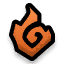

In [237]:
encode_image_to_base64("../ressources/MAPICONS/INFERNAL.png")

In [238]:
fig=px.bar(time_monst,
            x="Subtype",
            y="Time",
            color="Subtype",
            width=500,
            color_discrete_map=time_monst_cols)
fig.update_traces(width=0.85).update_xaxes(showticklabels=False).update_layout(showlegend=False)
for elem in time_monst['Subtype']:
    fig.add_layout_image(
        source=encode_image_to_base64(f"../ressources/mapicons/{elem}.png"),
        x=elem,
        y=0.05,  # just below the chart
        xref="x",
        yref="paper",
        sizex=0.5,
        sizey=0.1,
        xanchor="center",
        yanchor="top",
        layer="above"
    )
fig.show()

In [239]:
monsters.loc[monsters.groupby(['match_id','Type'])['Time'].idxmin()].groupby(['Type','Team']).aggregate({'Time':'mean'})

Time
Type         Team           
BARON_NASHOR BLUE  27.700500
             RED   27.475341
DRAGON       BLUE  12.291053
             RED   12.069410
RIFT_HERALD  BLUE  14.525390
             RED   14.406417

In [240]:
monsters[monsters['match_id']==7619].sort_values(['Time'])

Team    Time          Type  match_id   Subtype
22131  BLUE  16.195   RIFT_HERALD      7619      None
36789   RED  16.217        DRAGON      7619  MOUNTAIN
14126  BLUE  22.787        DRAGON      7619  INFERNAL
42359   RED  26.427  BARON_NASHOR      7619      None
36788   RED  29.624        DRAGON      7619     CLOUD
42360   RED  35.277  BARON_NASHOR      7619      None
36787   RED  35.963        DRAGON      7619     ELDER

## Timeline:
A timeline over time. For individual games inspired from spectator one. Bar with event related icon at referred minute.
For sets of games or general view use average time for event N. Note that for aggregate views events would be drake_0, drake_1, ... same for baron and turrets.

Click on it to make it on multiple lines and have the data less condensed.

For the agglomeration, add cardinality of item in each individual dataset.
Build "Events" dataset taking only the event identification + game_id + cardinality + timestamp from these datasets.

In [241]:
structures['Team'] = structures['Team'].apply(lambda x: 'RED' if (x[0]=='r' or x[0]=='R') else 'BLUE')
structures = structures.dropna()

In [242]:
monsters['cardinality'] = monsters.sort_values("Time").groupby("match_id").cumcount()
monsters['type_cardinality'] = monsters.sort_values("Time").groupby(["match_id","Type"]).cumcount().astype(int)
kills['cardinality'] = kills.sort_values("Time").groupby("match_id").cumcount()
structures['cardinality'] = structures.sort_values("Time").groupby("match_id").cumcount()
structures['type_cardinality'] = structures.sort_values("Time").groupby(["match_id","Type"]).cumcount().astype(int)

C:\Users\Loïc\AppData\Local\Temp\ipykernel_20032\2469197175.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Loïc\AppData\Local\Temp\ipykernel_20032\2469197175.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [243]:
structures

Team    Time      Lane          Type  match_id  cardinality  \
0       BLUE  27.542  MID_LANE   BASE_TURRET         0            8   
1       BLUE  39.269  MID_LANE  NEXUS_TURRET         0           13   
2       BLUE  33.583  BOT_LANE  INNER_TURRET         0           10   
3       BLUE  23.038  TOP_LANE  INNER_TURRET         0            7   
4       BLUE  16.556  BOT_LANE  OUTER_TURRET         0            3   
...      ...     ...       ...           ...       ...          ...   
121380   RED  18.959  BOT_LANE     INHIBITOR      7617            6   
121381   RED  22.992  TOP_LANE     INHIBITOR      7617            9   
121383   RED  37.152  BOT_LANE     INHIBITOR      7619           10   
121384   RED  41.194  TOP_LANE     INHIBITOR      7619           16   
121385   RED  37.880  MID_LANE     INHIBITOR      7619           12   

        type_cardinality  
0                      0  
1                      0  
2                      2  
3                      1  
4                      2  
...                  ...  
121380                 0  
121381                 1  
121383                 0  
121384                 2  
121385                 1  

[113780 rows x 7 columns]

In [244]:
structures['Lane'] = structures['Lane'].apply(lambda x: x.split('_')[0])
structures['Type'] = structures['Type'].apply(lambda x: x.split('_')[0])

C:\Users\Loïc\AppData\Local\Temp\ipykernel_20032\3832433758.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Loïc\AppData\Local\Temp\ipykernel_20032\3832433758.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [245]:
# Boolean mask where Type is "NEXUS"
nexus_mask = structures['Type'] == 'NEXUS'
# Replace 'Lane' with "NEXUS" where Type is "NEXUS"
#structures.loc[nexus_mask, 'Lane'] = 'NEXUS'
# Set 'Type' to "UPPER" or "LOWER" based on even/odd type_cardinality
structures.loc[nexus_mask, 'Lane'] = np.where(
    structures.loc[nexus_mask, 'type_cardinality'] % 2 == 0,
    'UPPER',
    'LOWER'
)

In [248]:
monsters.groupby(['cardinality', 'Type']).aggregate(count=('Type','size'),avg_time=('Time','mean')).reset_index()

cardinality          Type  count   avg_time
0             0  BARON_NASHOR     20  26.401100
1             0        DRAGON   6586  11.695664
2             0   RIFT_HERALD   1014  12.065129
3             1  BARON_NASHOR    275  24.099262
4             1        DRAGON   5131  17.704500
5             1   RIFT_HERALD   2198  14.726736
6             2  BARON_NASHOR   1493  24.978360
7             2        DRAGON   5096  21.866591
8             2   RIFT_HERALD    884  16.991594
9             3  BARON_NASHOR   2845  26.946892
10            3        DRAGON   3918  25.940225
11            3   RIFT_HERALD    190  17.485895
12            4  BARON_NASHOR   2370  30.237886
13            4        DRAGON   3238  29.721266
14            4   RIFT_HERALD     79  18.296456
15            5  BARON_NASHOR   1706  34.336356
16            5        DRAGON   2227  33.075567
17            5   RIFT_HERALD      3  19.393667
18            6  BARON_NASHOR   1167  37.064939
19            6        DRAGON   1267  37.096048
20            7  BARON_NASHOR    597  41.316690
21            7        DRAGON    710  39.873059
22            8  BARON_NASHOR    328  45.173107
23            8        DRAGON    320  43.898297
24            9  BARON_NASHOR    150  48.307267
25            9        DRAGON    160  49.443044
26           10  BARON_NASHOR     80  53.425262
27           10        DRAGON     71  51.398761
28           11  BARON_NASHOR     31  56.244677
29           11        DRAGON     37  56.796270
30           12  BARON_NASHOR     17  60.385000
31           12        DRAGON     10  60.846400
32           13  BARON_NASHOR      6  65.879500
33           13        DRAGON      6  63.527000
34           14  BARON_NASHOR      5  68.293000
35           14        DRAGON      3  68.909000
36           15  BARON_NASHOR      1  77.290000
37           15        DRAGON      2  70.799000
38           16  BARON_NASHOR      1  78.340000
39           16        DRAGON      2  77.247500
40           17  BARON_NASHOR      2  79.786000
41           18        DRAGON      1  92.180000
42           19  BARON_NASHOR      1  92.364000

In [249]:
def get_objective_distribution(monsters: pd.DataFrame, normalized: bool=True) -> go.Figure:
    # Count monsters by type for each cardinality
    grouped_counts = monsters.groupby(['cardinality', 'Type']).aggregate(count=('Type','size'),avg_time=('Time','mean')).reset_index()
    grouped_counts['avg_time_str'] = grouped_counts['avg_time'].apply(format_time)
    if normalized:
        grouped_counts['percent'] = grouped_counts['count'] / grouped_counts.groupby('cardinality')['count'].transform('sum')
        grouped_counts['percent_str'] = (grouped_counts['percent'] * 100).map("{:.2f}%".format)
        labels = {'cardinality': 'Cardinality', 'percent_str': 'Percentage', 'count':'Count', 'avg_time_str':'Average Time'}
        hover_data={'cardinality': True, 'percent':False, 'percent_str': True, 'count': True, 'Type': True, 'avg_time_str':True}
        y='percent'
    else:
        labels = {'cardinality': 'Cardinality', 'count': 'Count', 'avg_time_str':'Average Time'}
        hover_data={'cardinality': True, 'Type': True, 'count': True, 'avg_time_str':True}
        y='count'

    fig = px.bar(
        grouped_counts,
        x='cardinality',
        y=y,
        color='Type',
        title='Distribution of Types by Cardinality',
        labels=labels,
        hover_data=hover_data,
        barmode='stack'
    )
    return fig

In [260]:
import colorsys

def hex_to_rgb(hex_color):
    """Convert hex color to RGB tuple (0–1 scale)."""
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i:i+2], 16)/255.0 for i in (0, 2, 4))

def rgb_to_hex(rgb):
    """Convert RGB tuple (0–1 scale) to hex color."""
    return '#{:02x}{:02x}{:02x}'.format(
        int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255)
    )

def generate_shades_plotly(hex_color, n_shades=3):
    """Generate n_shades of a hex color using HSV value scaling."""
    r, g, b = hex_to_rgb(hex_color)
    h, s, v = colorsys.rgb_to_hsv(r, g, b)

    value_steps = [0.5, 0.7, 0.9][:n_shades]  # Brightness levels
    shades = [colorsys.hsv_to_rgb(h, s, val) for val in value_steps]

    return [rgb_to_hex(rgb) for rgb in shades]


In [261]:
def get_struct_distribution(structures: pd.DataFrame, normalized: bool=True) -> go.Figure:
    # Count monsters by type for each cardinality
    # Define your 6 base colors for each Type (can be adjusted as needed)
    base_colors = {
        'TURRET': '#1f77b4',      # Blue
        'INHIBITOR': '#d62728',   # Red
        'NEXUS': '#9467bd',       # Purple
        'BASE': '#ff7f0e',        # Orange
    }

    # List of lanes
    lanes = ['TOP', 'MID', 'BOT', 'UPPER', 'LOWER']
    # Create full mapping
    color_map = {}
    for t, base_color in base_colors.items():
        shades = generate_shades(base_color, len(lanes))
        for lane, shade in zip(lanes, shades):
            color_map[f'{t}_{lane}'] = shade

    grouped_counts = structures.groupby(['cardinality', 'Type', 'Lane']).aggregate(count=('Type','size'),avg_time=('Time','mean')).reset_index()
    grouped_counts['avg_time_str'] = grouped_counts['avg_time'].apply(format_time)
    if normalized:
        grouped_counts['percent'] = grouped_counts['count'] / grouped_counts.groupby('cardinality')['count'].transform('sum')
        grouped_counts['percent_str'] = (grouped_counts['percent'] * 100).map("{:.2f}%".format)
        labels = {'cardinality': 'Cardinality', 'percent_str': 'Percentage', 'count':'Count', 'avg_time_str':'Average Time'}
        hover_data={'cardinality': True, 'percent':False, 'percent_str': True, 'count': True, 'Type': True, 'avg_time_str':True}
        y='percent'
    else:
        labels = {'cardinality': 'Cardinality', 'count': 'Count', 'avg_time_str':'Average Time'}
        hover_data={'cardinality': True, 'Type': True, 'Lane': True, 'count': True, 'avg_time_str':True}
        y='count'

    grouped_counts['Type_Lane'] = grouped_counts['Type'] + '_' + grouped_counts['Lane']
    fig = px.bar(
        grouped_counts,
        x='cardinality',
        y=y,
        color='Type_Lane',
        title='Distribution of Types by Cardinality',
        labels=labels,
        hover_data=hover_data,
        barmode='stack'
    )
    return fig

In [262]:
get_struct_distribution(structures, False).show()

In [ ]:
get_objective_distribution(monsters, False).show()

In [ ]:
structures = structures[structures['Type'] != 'FOUNTAIN']

In [ ]:
import time
def create_timeline(df: pd.DataFrame, hover_labels: List[str]) -> go.Figure:
    """ Creates a timeline using df's data, df needs columns: 'count', 'Time' and 'icon_name'.
    Labels to show when hovering given separately.
    """
    fig = go.Figure()
    
    x_size = df['Time'].max() + 1
    
    tot_count = df['count'].sum()
    df['size'] = x_size/100+10*(df['count']/tot_count)  # Base size related with x axis and scales with proportion
    max_s_icon = df['size'].max()

    # x_tol defines when a neighbouring icon is to be offset by y_step. Both in funciton of icon size
    x_tol = max_s_icon*0.15
    y_step = max_s_icon

    y_values = []
    previous_x = -100
    previous_y = y_step
    # Add one image per event
    for _, row in df.iterrows():
        img_path = f'../ressources/mapicons/{row['icon_name']}.png'
        x = row['Time']
        if x-(previous_x+x_tol) < 0: y = previous_y+y_step
        else: y = y_step
        if os.path.exists(img_path):
            fig.add_layout_image(
                source=encode_image_to_base64(img_path),
                x=x,
                y=y,
                xref="x",
                yref="y",
                sizex=row['size'],
                sizey=row['size'],
                xanchor="center",
                yanchor="middle",
                layer="above"
            )
        else: # TODO: EXCEPTION HANDLING? 
            print(f"Image not found: {img_path}")
        # Keep track of y positioning
        previous_x = x
        previous_y = y
        y_values.append(y)
    fig.add_trace(go.Scatter(
                x=df['Time'],
                y=y_values,
                mode='markers',
                marker=dict(size=df['size'], color='rgba(0,0,0,0)'),  # invisible
                hoverinfo='text',
                text=hover_labels,
                showlegend=False
            ))
    print(max_s_icon)
    print(round(max_s_icon*(np.unique(y_values).size+2))*100)
    print(round(max_s_icon*(np.unique(y_values).size+2))*10)
    fig.update_layout(
        xaxis=dict(
            range=[0, x_size],  # pad the view: game time
            #title="Time",
            showline=False,
            showticklabels=True,
            tickmode='auto',
        ),
        yaxis=dict(
            range=[0, max(y_values)+max_s_icon],  # pad the view: consider icon size
            visible=True,
            showline=True,
            showticklabels=False,
            tickvals=np.unique(y_values),   # To put horizontal lines at level of icons
        ),
        margin=dict(t=40, b=40), # TODO: DETERMINED BY DASH?
        height=200, # TODO: DETERMINED BY DASH?
    )
    return fig

def get_monsters_timeline(df: pd.DataFrame) -> go.Figure:
    """ Creates a timeline of killed neutral objectives over time. 
    Should receive the data for a single match, or aggregated data"""
    # Team column is killer team
    if df['match_id'].unique().size > 1:
        # Do not consider Subtype in aggregate, because too much detail
        g_df = df.groupby(['Type','type_cardinality','Team']).aggregate(count=('Type','size'),Time=('Time','mean')).sort_values('Time').reset_index()
        g_df['icon_name'] = g_df['Team'] + '_' + g_df['Type'] # TODO: Do in preprocessing?
        hover_labels = [f"<b>{row['Type']}</b><br>At: {format_time(row['Time'])}<br>Count: {row['count']}" for _, row in g_df.iterrows()]
    else: 
        g_df = df
        g_df['count'] = 1
        g_df['icon_name'] = df['Team'] + '_' + np.where(df['Subtype'].notna(), df['Subtype'], df['Type']) # TODO: Do in preprocessing?
        hover_labels = [f"<b>{row['Type']}</b><br>At: {format_time(row['Time'])}" for _, row in g_df.iterrows()]
    return create_timeline(g_df, hover_labels)

def get_structures_timeline(df: pd.DataFrame) -> go.Figure:
    """ Creates a timeline of destroyed structures over time. 
    Should receive the data for a single match, or aggregated data"""
    df['Time'].astype(float,False)
    g_df = df.groupby(['Type','Lane','Team']).aggregate(count=('Type','size'),Time=('Time','mean')).sort_values('Time').reset_index()
    # Team column is destroyer team -> destroyed (Blue turret destroyed)    
    g_df['icon_name'] = g_df['Team'].replace({'BLUE': 'RED', 'RED': 'BLUE'}) + '_' + np.where(g_df['Type'] == 'INHIBITOR', 'INHIBITOR', 'TURRET')
    hover_labels = [f"<b>{row['Lane']} {f"{row['Type']} Turret" if row['Type']!="INHIBITOR" else row['Type']}</b><br>At: {format_time(row['Time'])}{"<br>Count: "+str(row['count']) if df['match_id'].unique().size > 1 else ""}" for _, row in g_df.iterrows()]
    return create_timeline(g_df, hover_labels)

In [ ]:
fix_m = monsters[monsters['match_id']==7619].sort_values('Time')
fix_s = structures[structures['match_id']==7619].sort_values('Time')

In [ ]:
get_monsters_timeline(fix_m).show()

1.7982014285714283
700
70


In [ ]:
get_monsters_timeline(monsters).show()

1.8588795588501175
700
70


In [ ]:
fix_s

Team    Time   Lane       Type  match_id  cardinality  \
97381    RED  13.564    NaN      OUTER      7619            0   
51647   BLUE  13.644    NaN      OUTER      7619            1   
51649   BLUE  13.663    NaN      OUTER      7619            2   
97380    RED  17.922    NaN      OUTER      7619            3   
51646   BLUE  18.042    NaN      OUTER      7619            4   
97379    RED  21.801    NaN      OUTER      7619            5   
51648   BLUE  23.904    NaN      INNER      7619            6   
97376    RED  28.844    NaN      INNER      7619            7   
97371    RED  32.298    NaN      INNER      7619            8   
97377    RED  37.034    NaN       BASE      7619            9   
121383   RED  37.152    NaN  INHIBITOR      7619           10   
97378    RED  37.761    NaN       BASE      7619           11   
121385   RED  37.880    NaN  INHIBITOR      7619           12   
97374    RED  38.456    NaN      INNER      7619           13   
97372    RED  40.779    NaN       BASE      7619           14   
97373    RED  41.053  NEXUS      UPPER      7619           15   
121384   RED  41.194    NaN  INHIBITOR      7619           16   
97375    RED  41.317  NEXUS      LOWER      7619           17   

        type_cardinality  
97381                  0  
51647                  1  
51649                  2  
97380                  3  
51646                  4  
97379                  5  
51648                  0  
97376                  1  
97371                  2  
97377                  0  
121383                 0  
97378                  1  
121385                 1  
97374                  3  
97372                  2  
97373                  0  
121384                 2  
97375                  1

In [ ]:
get_structures_timeline(fix_s).show()

0.9787255555555556
500
50


In [ ]:
get_structures_timeline(structures).show()

0.9823246146383114
500
50


## Monster avg time type distribution

In [ ]:
time_monst2 = monsters.copy()
time_monst2['TimeRound'] = monsters['Time'].apply(round)

In [ ]:
time_monst2=time_monst2.groupby(['TimeRound']).count().sort_values('TimeRound')

In [ ]:
time_monst2

Team  Time  Type  match_id  Subtype  cardinality
TimeRound                                                  
3            11    11    11        11        0           11
4           119   119   119       119       48          119
5            70    70    70        70       19           70
6           376   376   376       376      132          376
7           356   356   356       356      146          356
...         ...   ...   ...       ...      ...          ...
77            2     2     2         2        0            2
78            1     1     1         1        0            1
82            1     1     1         1        1            1
85            1     1     1         1        0            1
92            2     2     2         2        1            2

[77 rows x 6 columns]

## Win Rate by side

In [ ]:
matchinfo

League  Year  Season    Type blueTeamTag  bResult  rResult redTeamTag  \
0     NALCS  2015  Spring  Season         TSM        1        0         C9   
1     NALCS  2015  Spring  Season         CST        0        1        DIG   
2     NALCS  2015  Spring  Season         WFX        1        0         GV   
3     NALCS  2015  Spring  Season         TIP        0        1         TL   
4     NALCS  2015  Spring  Season         CLG        1        0         T8   
...     ...   ...     ...     ...         ...      ...      ...        ...   
7615    TCL  2018  Spring  Season          YC        0        1        SUP   
7616    TCL  2018  Spring  Season         GAL        0        1         DP   
7617    OPL  2018  Spring  Season         SIN        0        1         DW   
7618    OPL  2018  Spring  Season         LGC        1        0        TTC   
7619    OPL  2018  Spring  Season         TTC        0        1        LGC   

      gamelength   blueTop  ... redTopChamp     redJungle redJungleChamp  \
0             40     Dyrus  ...        Gnar        Meteos          Elise   
1             38      Cris  ...      Irelia       Crumbzz       JarvanIV   
2             40   Flaresz  ...        Sion  Saintvicious         LeeSin   
3             41      Rhux  ...        Gnar    IWDominate           Nunu   
4             35     Benny  ...        Sion     Porpoise8         RekSai   
...          ...       ...  ...         ...           ...            ...   
7615          34    Elwind  ...     Chogath      Stomaged        XinZhao   
7616          39      Rare  ...     Chogath         KaKAO          Ivern   
7617          24  Praedyth  ...   Gangplank       Praelus        Evelynn   
7618          35     Ceres  ...   Gangplank        Swathe       JarvanIV   
7619          42   Papryze  ...        Ornn         Sybol       JarvanIV   

     redMiddle redMiddleChamp        redADC redADCChamp   redSupport  \
0          Hai           Fizz        Sneaky       Sivir  LemonNation   
1     Shiphtur           Azir        CoreJJ       Corki      KiWiKiD   
2        Keane           Azir           Cop       Corki   BunnyFuFuu   
3        Fenix           Lulu         KEITH      KogMaw      Xpecial   
4     Slooshi8           Lulu  Maplestreet8       Corki        Dodo8   
...        ...            ...           ...         ...          ...   
7615       GBM         Veigar       Zeitnot       Xayah   SnowFlower   
7616    Lucete           Ryze      Ruvelius     Caitlyn       Japone   
7617    Triple       Malzahar          k1ng      Ezreal      Cupcake   
7618      Shok         Veigar           Low       Sivir      Tilting   
7619    Claire       Malzahar          Raid       Vayne        Decoy   

     redSupportChamp match_id  
0             Thresh        0  
1              Annie        1  
2              Janna        2  
3              Janna        3  
4              Annie        4  
...              ...      ...  
7615           Rakan     7615  
7616           Braum     7616  
7617           Taric     7617  
7618           Janna     7618  
7619           Braum     7619  

[7620 rows x 30 columns]

In [ ]:
wins=matchinfo.loc[:,['bResult','rResult']].sum()
d = {"WIN RATE BLUE":wins[0]/wins.sum()*100,"WIN RATE RED":wins[1]/wins.sum()*100}

C:\Users\Loïc\AppData\Local\Temp\ipykernel_14564\1212502597.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [ ]:
fig=px.bar(x=d.keys(),
       y=d.values(),
       color=d.keys(),
       width=500,
       color_discrete_map=dict(zip(d.keys(),('blue','red'))))
fig.update_traces(width=0.75)
fig.show()

# Gantt chart

In [ ]:
import plotly.express as px
import pandas as pd

import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

# Your data
df = pd.DataFrame([
    dict(Task="Project", Start='2025-04-24', Finish='2025-05-22'),
    dict(Task="Create base Dash structure", Start='2025-04-25', Finish='2025-05-02'),
    dict(Task="Create all base visualisations", Start='2025-04-25', Finish='2025-05-05'),
    dict(Task="Link visualisations with Dash", Start='2025-05-02', Finish='2025-05-06'),
    dict(Task="Implement filters & interconnectivity", Start='2025-05-05', Finish='2025-05-12'),
    dict(Task="(OPTIONAL) Expand dataset", Start='2025-05-05', Finish='2025-05-19'),
    dict(Task="Apply Final polish", Start='2025-05-12', Finish='2025-05-19'),
    dict(Task="Validate & Evaluate", Start='2025-05-14', Finish='2025-05-21'),
    dict(Task="Prepare Final presentation", Start='2025-05-19', Finish='2025-05-22'),
    dict(Task="Prepare Deliverables & Write Report", Start='2025-05-22', Finish='2025-05-25'),
])

# Define custom colors
colors = {
    task: "#3d7094" if "(OPTIONAL)" in task else "#1f77b4"  # less saturated for optional
    for task in df["Task"]
}

# Create the Gantt chart
fig = px.timeline(df, x_start="Start", x_end="Finish", y="Task", color="Task", color_discrete_map=colors)
fig.update_layout(showlegend=False)
fig.update_yaxes(autorange="reversed")

# Add dotted vertical lines for each day
start_date = pd.to_datetime(df["Start"].min())
end_date = pd.to_datetime(df["Finish"].max())

for d in pd.date_range(start=start_date, end=end_date):
    fig.add_vline(
        x=d,
        line=dict(color='rgba(60, 60, 60, 0.5)', width=1, dash="dot"),
        layer="above"
    )

# Add red lines
highlight_lines = [
    ('2025-04-24', 'dot', "Progress<br>Presentation"),  # dotted red
    ('2025-05-22', 'solid', 'Final<br>Presentation'),  # solid red
    ('2025-05-25', 'solid', 'Deliverables')   # solid red
]

for date_str, dash, label in highlight_lines:
    # Red vertical line
    fig.add_vline(
        x=date_str,
        line=dict(color='red', width=2, dash=dash)
    )
    # Annotation below chart
    fig.add_annotation(
        x=date_str,
        y=1.02,  # slightly below visible chart
        xref='x',
        yref='paper',
        text=label,
        showarrow=False,
        yanchor='bottom',
        xanchor='center',
        font=dict(color='red', size=12)
    )

fig.update_layout(
    title="Gantt Chart of future progress",
    margin=dict(t=100)  # Extra space at bottom for annotations
)

fig.show()
